In [26]:
import numpy as np
import tifffile
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os

import pyvips
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
dataset_folder = '../dataset/'
train_folder = f'{dataset_folder}train/'

In [3]:
format_to_dtype = {
    'uchar': np.uint8,
    'char': np.int8,
    'ushort': np.uint16,
    'short': np.int16,
    'uint': np.uint32,
    'int': np.int32,
    'float': np.float32,
    'double': np.float64,
    'complex': np.complex64,
    'dpcomplex': np.complex128,
}

In [4]:
def vips2numpy(vi):
    return np.ndarray(buffer=vi.write_to_memory(),
                      dtype=format_to_dtype[vi.format],
                      shape=[vi.height, vi.width, vi.bands])

In [5]:
images_paths = []
masks_paths = []
for item in os.listdir(train_folder):
    if '.tiff' not in item:
        continue
    if '_mask' in item:
        masks_paths.append(train_folder + item)
    else:
        images_paths.append(train_folder + item)
images_paths = sorted(images_paths)
masks_paths = sorted(masks_paths)

In [6]:
## Check correspondense
if len(images_paths) != len(masks_paths):
    raise ValueError('Lists have different sizes')
    
for image, mask in zip(images_paths, masks_paths):
    if image != mask.replace('_mask', ''):
        raise(f'{image} has no mask or masks is in wrong order')
print('OK')

OK


In [7]:
def crop(image, patch_size, x, y):
    """
    Crop  square form pyvips image
    :param image: pyvips image.
    :param patch_size: size of square to be croped from image .
    :param x: x coordinate of top left point.
    :param y: y coordinate of top left point.
    :return: return croped pyvips image.
    """
    return image.crop(patch_size * x, patch_size * y, patch_size, patch_size)

In [8]:
def split(path, patch_size, padding=True):
    """
    Split image by patch_size without loading it to RAM.
    :param path: Path to image.
    :param patch_size: Size of square to be splitted.
    :param padding: If True make morror padding.
    :return: List of pyvips cropes and ids for fetch.
    """
    patches = []
    ids = []
    img = pyvips.Image.new_from_file(path)
    if padding:
        new_width = int(np.ceil(img.width / patch_size)) * patch_size
        new_height = int(np.ceil(img.height / patch_size)) * patch_size
        img = img.embed(0, 0, new_width, new_height, extend='mirror')
    else:
        new_width = img.width
        new_height = img.height
        
    x_num = new_width // patch_size
    y_num = new_height // patch_size
    for y in range(y_num):
        for x in range(x_num):
            patches.append(crop(img, patch_size, x, y))
            ids.append((path, x, y))
    return patches, ids

In [9]:
patch_size = 768

In [10]:
masks = []
image_ids = []
for mask_path in masks_paths:
    result = split(mask_path, patch_size=patch_size)
    masks += result[0]
    image_ids += result[1]

In [12]:
is_with_object = np.zeros(len(masks)).astype(np.int8)

In [13]:
def check_object(item):
    return int(np.sum(vips2numpy(item)) > 0)

In [14]:
for i, item in tqdm(enumerate(masks), total=len(masks)):
    is_with_object[i] = check_object(item)

100%|██████████| 12345/12345 [03:00<00:00, 68.58it/s] 


(array([10104.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2241.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

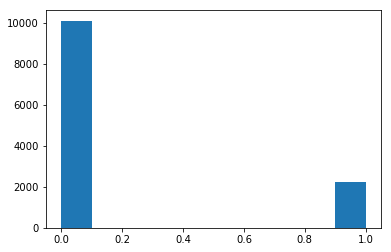

In [15]:
plt.hist(is_with_object.squeeze())

In [21]:
## Create dicts and label paths
mask2ind = {}
image2ind = {}
ind2mask = {}
ind2image = {}
dataset = np.array(image_ids)
uniq_mask_path = np.unique(dataset[:,0])
for i, item in enumerate(uniq_mask_path):
    mask2ind[item] = i
    ind2mask[i] = item
    image2ind[item.replace('_mask', '')] = i
    ind2image[i] = item.replace('_mask', '')
dataset[:, 0] = np.vectorize(mask2ind.get)(dataset[:, 0])
dataset = dataset.astype(np.int)

In [22]:
X_train, X_test = train_test_split(dataset, 
                 train_size=0.8, 
                 test_size=0.2, 
                 stratify=is_with_object.squeeze(),
                 random_state=42)

In [42]:
class HubDataset(Dataset):
    def __init__(self, dataset, patch_size, ind2image, ind2mask, transform=None):
        
        self.dataset = dataset
        self.patch_size = patch_size
        self.ind2image = ind2image
        self.ind2mask = ind2mask
        if transform is not None:
            self.transform = transform
        else:
            self.transform = self.transform_default
        self.images = self.load_images()
        self.masks = self.load_masks()
        
        
    def load_images(self):
        pass
    
    def load_masks(self):
        pass
    
    def transform_default(self):
        pass
    
    def get_image(self, image_objct, x, y):
        pass

    
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        ind, patch_size, x, y = self.dataset[idx]
        image = self.get_image(self.images[ind], x, y)
        mask = self.get_image(self.masks[ind], x, y)
        aug = self.transform(image=image, mask=mask)
        image = aug['image']
        mask = aug['mask']
        image = torch.Tensor(image.permute(2, 0, 1))
        return image, mask